In [1]:
import torch
from torch import nn

from torch.optim import SGD, Adam

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
import bezier

In [6]:
controls = np.random.normal(size=(10, 2))

In [93]:
controls = np.array([
    [0, 1],
    [1, 0],
    [2, 3],
    [3, 0],
])

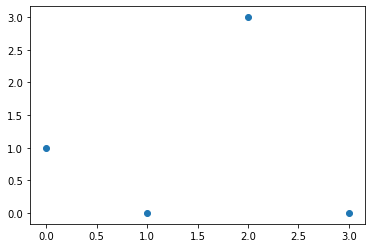

In [8]:
plt.scatter(*controls.T)

In [9]:
ts = np.linspace(0, 1, 100)

In [10]:
curve = np.array([bezier.compute(t, controls) for t in ts])

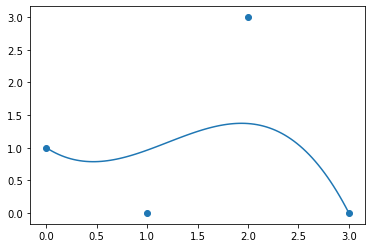

In [11]:
plt.scatter(*controls.T)
plt.plot(*curve.T)

In [12]:
cloud = torch.randn(*curve.shape) * .1 + torch.Tensor(curve)

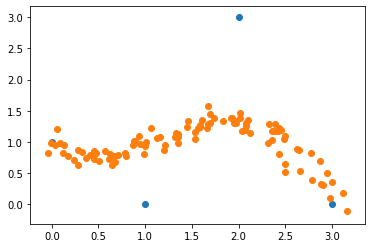

In [13]:
plt.scatter(*controls.T)
plt.scatter(*cloud.t())

In [163]:
b = bezier.Bezier(4, 100, cloud)
# b = bezier.Bezier(4, 100, None)

choice = torch.Tensor([
    [0, 1],
    [1, 1],
    [2, 1],
    [3, 1],
])
# b = bezier.Bezier(4, 100, choice)

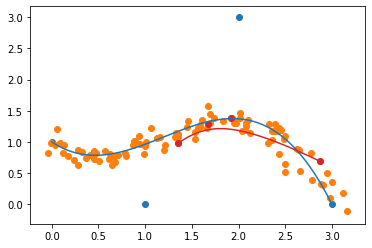

In [164]:
plt.scatter(*controls.T, color='C0')
plt.plot(*curve.T, color='C0')

plt.scatter(*cloud.t(), color='C1')


plt.scatter(*b.controls.detach().numpy().T, color='C3')
plt.plot(*b().detach().numpy().T, color='C3')

In [166]:
loss = bezier.BezierLoss(alpha=1e-3)
# loss = bezier.BezierLoss('min')

In [167]:
loss(b(), cloud)

tensor(0.1670, grad_fn=<AddBackward0>)

In [168]:
optimizer = Adam(b.parameters(), lr=.1)

In [169]:
def train(steps=100):
    for step in range(steps):
        b.zero_grad()
        
        l = loss(b(), cloud)
        l.backward()
        
        optimizer.step()
        
#        if step > 0 and step % 10 == 0:
#            plt.scatter(*controls.T, color='C0')
#            plt.plot(*curve.T, color='C0')

#            plt.scatter(*cloud.t(), color='C1')


#            plt.scatter(*b.controls.detach().numpy().T, color='C3')
#            plt.plot(*b().detach().numpy().T, color='C3')
           
#            plt.show()

In [170]:
from matplotlib import animation

In [171]:
# b.controls.data += 1
# optimizer = Adam(b.parameters(), lr=.05)

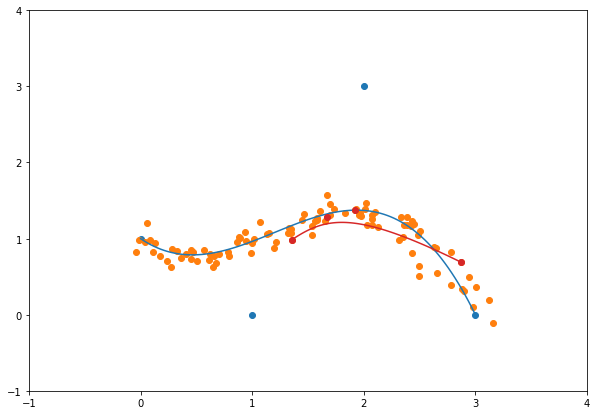

In [172]:
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(xlim=(-1, 4), ylim=(-1, 4))
ax.scatter(*controls.T, color='C0')
ax.plot(*curve.T, color='C0')

ax.scatter(*cloud.t(), color='C1')

line, = ax.plot([], [], color='C3')
anchors, = ax.plot([], [], 'bo', color='C3')

# initialization function: plot the background of each frame
def init():
    
    line.set_data(*b().detach().numpy().T)
    anchors.set_data(*b.controls.detach().numpy().T)
    return line,

# animation function.  This is called sequentially
def animate(i):
    train(1)
    line.set_data(*b().detach().numpy().T)
    anchors.set_data(*b.controls.detach().numpy().T)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

In [173]:
anim.save('random-init.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

In [174]:
c = b.controls.data

In [140]:
c + torch.randn_like(c)

tensor([[-0.2823, -0.1945],
        [ 1.5553,  1.6017],
        [-0.1811,  3.8774],
        [ 2.7599,  0.0216]])

In [141]:
b2 = bezier.Bezier(4, 100, b.controls.data + )

SyntaxError: invalid syntax (<ipython-input-141-7e92248883e0>, line 1)

In [ ]:
c = b.controls.data + torch.randn_like(c) * .11

b2 = bezier.Bezier(4, 100, c)

plt.scatter(*controls.T, color='C0')
plt.plot(*curve.T, color='C0')

plt.scatter(*cloud.t(), color='C1')


plt.scatter(*b2.controls.detach().numpy().T, color='C3')
plt.plot(*b2().detach().numpy().T, color='C3')